In [1]:
import pandas as pd
import numpy as np
import random
from itertools import combinations
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.nn import HANConv
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, 
    roc_auc_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os
import random
from torch_geometric.nn import HANConv
os.chdir("D:\\mywork\\lincGNN\\cal")

D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
edges_df = pd.read_csv('Net_final.csv', index_col=0)
print(edges_df)

for col in edges_df.columns[0:]:
    print(f"distribution - {col}:")
    print(edges_df[col].value_counts())
    print("\n")


       Regulator       Target RegulatorType TargetType regulatory_Mechanism
1          NEAT1   miR-194-5p        lncRNA      miRNA      ceRNA or sponge
2      LINC00460      miR-206        lncRNA      miRNA      ceRNA or sponge
3         MALAT1      miR-497        lncRNA      miRNA      ceRNA or sponge
4           MIAT      miR-29b        lncRNA      miRNA      ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p        lncRNA      miRNA      ceRNA or sponge
...          ...          ...           ...        ...                  ...
9513       WWTR1         YAP1           PCG        PCG            interacts
9514        YAP1        YWHAH           PCG        PCG            interacts
9515        YAP1        YWHAZ           PCG        PCG            interacts
9516        YAP1         YES1           PCG        PCG            interacts
9517       YWHAH        YWHAZ           PCG        PCG            interacts

[9517 rows x 5 columns]
distribution - Regulator:
MALAT1       258
HOTAIR       208
H19

In [3]:
edges_df.columns = ['A', 'B', 'A_type', 'B_type', 'relation']
print(edges_df)

               A            B  A_type B_type         relation
1          NEAT1   miR-194-5p  lncRNA  miRNA  ceRNA or sponge
2      LINC00460      miR-206  lncRNA  miRNA  ceRNA or sponge
3         MALAT1      miR-497  lncRNA  miRNA  ceRNA or sponge
4           MIAT      miR-29b  lncRNA  miRNA  ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p  lncRNA  miRNA  ceRNA or sponge
...          ...          ...     ...    ...              ...
9513       WWTR1         YAP1     PCG    PCG        interacts
9514        YAP1        YWHAH     PCG    PCG        interacts
9515        YAP1        YWHAZ     PCG    PCG        interacts
9516        YAP1         YES1     PCG    PCG        interacts
9517       YWHAH        YWHAZ     PCG    PCG        interacts

[9517 rows x 5 columns]


In [4]:
lnc_feat_df = pd.read_csv('Label_final.csv', index_col=0)
print(lnc_feat_df)
for col in lnc_feat_df.columns[0:5]:
    print(f"distribution - {col}:")
    print(lnc_feat_df[col].value_counts())
    print("\n")


      Regulator  cell_proliferation_label  length  GC_content    A_freq  \
1       A2M-AS1                         1    2930    0.429693  0.282253   
2         AATBC                         1    4598    0.614180  0.221618   
3        ABALON                         0    1903    0.565423  0.216500   
4     ACTA2-AS1                         1    2450    0.483265  0.267347   
5      ACTG1P25                         1    2321    0.506247  0.234382   
..          ...                       ...     ...         ...       ...   
601       ZFAS1                         1    4527    0.463000  0.230616   
602   ZFHX4-AS1                         0    5012    0.348763  0.323224   
603   ZFPM2-AS1                         0    1655    0.373414  0.284592   
604  ZNF407-AS1                         1    4931    0.421821  0.301764   
605  ZNF667-AS1                         1    5588    0.405691  0.289907   

       T_freq    G_freq    C_freq  dimer_AA  dimer_AC  ...  tetramer_TTCG  \
1    0.288055  0.20000

In [5]:
lncrna_cluster_features = pd.read_csv('lncRNA_cluster_features.csv')
lncrna_cluster_features.rename(columns={lncrna_cluster_features.columns[0]: 'Regulator'}, inplace=True)
print(lncrna_cluster_features.head())

lncRNA_emb =  pd.read_csv('lncRNA_emb_features.csv')
lncRNA_emb.rename(columns={lncRNA_emb.columns[0]: 'Regulator'}, inplace=True)
print(lncRNA_emb.head())

    Regulator  cluster_k2  cluster_k3  cluster_k4  cluster_k5  cluster_k6  \
0       NEAT1           0           2           3           3           4   
1   LINC00460           0           2           3           3           4   
2      MALAT1           0           2           1           2           4   
3        MIAT           0           2           1           2           4   
4  CDKN2B-AS1           0           2           1           2           1   

   cluster_k7  cluster_k8  cluster_k9  cluster_k10  cluster_k11  
0           0           0           7            6            9  
1           0           0           4            6            9  
2           0           0           7            1           10  
3           0           0           7            1            1  
4           0           0           7            1           10  
    Regulator  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       NEAT1  -0.055863  -0.003457   0.064911   0.041244   0.041424 

In [6]:

merged_df = pd.merge(lnc_feat_df, lncrna_cluster_features, on='Regulator', how='inner')

merged_df = pd.merge(merged_df, lncRNA_emb, on='Regulator', how='inner')
#merged_df = pd.merge(lnc_feat_df, lncRNA_emb, on='Regulator', how='inner')
print(merged_df.head())
lnc_feat_df = merged_df

   Regulator  cell_proliferation_label  length  GC_content    A_freq  \
0    A2M-AS1                         1    2930    0.429693  0.282253   
1      AATBC                         1    4598    0.614180  0.221618   
2     ABALON                         0    1903    0.565423  0.216500   
3  ACTA2-AS1                         1    2450    0.483265  0.267347   
4   ACTG1P25                         1    2321    0.506247  0.234382   

     T_freq    G_freq    C_freq  dimer_AA  dimer_AC  ...  feature_119  \
0  0.288055  0.200000  0.229693       259       156  ...     0.043067   
1  0.164202  0.316007  0.298173       237       279  ...     0.152246   
2  0.218077  0.262218  0.303205       122        88  ...     0.017568   
3  0.249388  0.266122  0.217143       166       125  ...    -0.024900   
4  0.259371  0.231366  0.274882       127       136  ...     0.008745   

   feature_120  feature_121  feature_122  feature_123  feature_124  \
0     0.058663    -0.043484     0.030920     0.062948    -

In [7]:
new_order = ['Regulator', 'cell_proliferation_label'] + [col for col in lnc_feat_df.columns if col not in ['Regulator',
                                                                                                     'cell_proliferation_label']]

lnc_feat_df = lnc_feat_df[new_order]
print(lnc_feat_df.head())

cols = lnc_feat_df.columns.tolist()
new_cols = ['lncRNA', 'label'] + [f'feat_{i}' for i in range(1, len(cols)-1)]
lnc_feat_df.columns = new_cols

print(lnc_feat_df.head())

   Regulator  cell_proliferation_label  length  GC_content    A_freq  \
0    A2M-AS1                         1    2930    0.429693  0.282253   
1      AATBC                         1    4598    0.614180  0.221618   
2     ABALON                         0    1903    0.565423  0.216500   
3  ACTA2-AS1                         1    2450    0.483265  0.267347   
4   ACTG1P25                         1    2321    0.506247  0.234382   

     T_freq    G_freq    C_freq  dimer_AA  dimer_AC  ...  feature_119  \
0  0.288055  0.200000  0.229693       259       156  ...     0.043067   
1  0.164202  0.316007  0.298173       237       279  ...     0.152246   
2  0.218077  0.262218  0.303205       122        88  ...     0.017568   
3  0.249388  0.266122  0.217143       166       125  ...    -0.024900   
4  0.259371  0.231366  0.274882       127       136  ...     0.008745   

   feature_120  feature_121  feature_122  feature_123  feature_124  \
0     0.058663    -0.043484     0.030920     0.062948    -

In [8]:
# -------- Meta-path view construction functions --------
def metapath_lnc_mi_lnc(edges_df, lnc_list):
    """
    Construct the lncRNA–miRNA–lncRNA meta-path view.
    Returns edge_index for this view.
    """
    adj = {}
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'lncRNA' and row['B_type'] == 'miRNA':
            adj.setdefault(row['A'], set()).add(row['B'])
    mi2lnc = {}
    for lnc, mis in adj.items():
        for mi in mis:
            mi2lnc.setdefault(mi, set()).add(lnc)
    edge_set = set()
    for lnc_set in mi2lnc.values():
        for u, v in combinations(sorted(lnc_set), 2):
            edge_set.add((u, v))
    node2idx = {nid: i for i, nid in enumerate(lnc_list)}
    edges = list(edge_set)
    if len(edges) > 0:
        edge_index = torch.tensor([
            [node2idx[u] for u, v in edges] + [node2idx[v] for u, v in edges],
            [node2idx[v] for u, v in edges] + [node2idx[u] for u, v in edges]
        ], dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    return edge_index

def metapath_lnc_pcg_lnc(edges_df, lnc_list):
    """
    lncRNA–PCG–lncRNA
    """
    pcg2lnc = {}
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'lncRNA' and row['B_type'] == 'PCG':
            pcg2lnc.setdefault(row['B'], set()).add(row['A'])
    edge_set = set()
    for lnc_set in pcg2lnc.values():
        for u, v in combinations(sorted(lnc_set), 2):
            edge_set.add((u, v))
    node2idx = {nid: i for i, nid in enumerate(lnc_list)}
    edges = list(edge_set)
    if len(edges) > 0:
        edge_index = torch.tensor([
            [node2idx[u] for u, v in edges] + [node2idx[v] for u, v in edges],
            [node2idx[v] for u, v in edges] + [node2idx[u] for u, v in edges]
        ], dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    return edge_index


def metapath_lnc_pcg_pcg_lnc(edges_df, lnc_list):
    """
    lncRNA–PCG–PCG–lncRNA
    """

    lnc2pcg = {}
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'lncRNA' and row['B_type'] == 'PCG':
            lnc2pcg.setdefault(row['A'], set()).add(row['B'])
    pcg_edges = set()
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'PCG' and row['B_type'] == 'PCG':
            pcg_edges.add((row['A'], row['B']))
            pcg_edges.add((row['B'], row['A']))
    edge_set = set()
    for lncA in lnc_list:
        for pcg1 in lnc2pcg.get(lncA, []):
            for pcg2 in set([b for a, b in pcg_edges if a == pcg1]):
                for lncB in [lnc for lnc, pcgs in lnc2pcg.items() if pcg2 in pcgs]:
                    if lncA != lncB:
                        u, v = sorted([lncA, lncB])
                        edge_set.add((u, v))
    node2idx = {nid: i for i, nid in enumerate(lnc_list)}
    edges = list(edge_set)
    if len(edges) > 0:
        edge_index = torch.tensor([
            [node2idx[u] for u, v in edges] + [node2idx[v] for u, v in edges],
            [node2idx[v] for u, v in edges] + [node2idx[u] for u, v in edges]
        ], dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    return edge_index

In [9]:
# Build meta-path-based edge indices for lncRNA nodes
lnc_list = lnc_feat_df['lncRNA'].tolist()
edge_index1 = metapath_lnc_mi_lnc(edges_df, lnc_list)
edge_index2 = metapath_lnc_pcg_lnc(edges_df, lnc_list)
edge_index3 = metapath_lnc_pcg_pcg_lnc(edges_df, lnc_list)
edge_index_list = [edge_index1, edge_index2, edge_index3]

print(f"View1 edges (lnc-mi-lnc): {edge_index1.size(1)//2}")
print(f"View2 edges (lnc-pcg-lnc): {edge_index2.size(1)//2}")
print(f"View3 edges (lnc_pcg_pcg_lnc): {edge_index3.size(1)//2}")

View1 edges (lnc-mi-lnc): 594
View2 edges (lnc-pcg-lnc): 10391
View3 edges (lnc_pcg_pcg_lnc): 31654


In [10]:
edge_index1

tensor([[ 59, 369,  97,  ..., 157, 418, 596],
        [521, 581, 425,  ..., 141,  65, 355]])

In [11]:
# Prepare node features and labels for model input
feat_cols = [c for c in lnc_feat_df.columns if c.startswith('feat_')]
x = torch.tensor(lnc_feat_df[feat_cols].values, dtype=torch.float)
y = torch.tensor(lnc_feat_df['label'].values, dtype=torch.long)

# Train/validation/test split
idx = torch.arange(x.size(0))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.6 train, 0.2 val, 0.2 test

print(train_idx)

# PyG 2.x metadata definition: required for HANConv
node_types = ['lncRNA']
edge_types = [
    ('lncRNA', 'meta1', 'lncRNA'),  # Meta-path 1
    ('lncRNA', 'meta2', 'lncRNA'),  # Meta-path 2
    ('lncRNA', 'meta3', 'lncRNA'),  # Meta-path 2
]
metadata = (node_types, edge_types)

tensor([498,  46, 179, 173, 156, 502,  92, 520, 383, 105, 201, 203,  37, 266,
         88, 324, 562, 143, 132, 420, 144,  75, 504, 240, 353, 586, 224, 108,
         25,  64,  14,   0, 229, 517, 543, 299, 315,  49, 445,  16, 189, 411,
        298, 387, 127, 320, 282, 100, 583, 122, 533, 427, 416, 558, 218, 523,
         26, 256, 147, 232, 403, 566, 531,  97,   5, 486, 460, 185, 603, 437,
         96, 512, 407, 136, 426, 146, 278, 205, 373, 221, 448,   8, 186, 401,
        551, 488,  22, 103, 300,  41,  38,  58, 513, 265, 447,  43, 202, 354,
        524,  35,  48, 436, 175,  32,  67, 452,  84, 226, 302, 432, 116, 115,
        225, 510, 425, 419,  74,  13, 461, 345, 490, 587, 272, 442,  47,  94,
        227, 581,  27, 346, 462, 154, 392, 340, 190, 348, 476,   7, 269, 415,
        515, 390, 239, 431, 554, 468, 314, 267, 549, 311,  99, 297,  40, 555,
         31, 379, 585, 339, 567, 197, 213, 366, 526, 372, 220, 350, 317,  85,
        509, 413, 270, 423, 480, 365, 377, 394, 422, 469,  42, 3

In [12]:
print(metadata)

(['lncRNA'], [('lncRNA', 'meta1', 'lncRNA'), ('lncRNA', 'meta2', 'lncRNA'), ('lncRNA', 'meta3', 'lncRNA')])


In [13]:
class HANforLncRNA(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, metadata, dropout=0.5, heads=8):
        super().__init__()
        self.metadata = metadata  # Store metadata internally
        self.han = HANConv(
            in_channels=in_dim,
            out_channels=hidden_dim,
            metadata=metadata,
            heads=heads,
        )
        self.lin = nn.Linear(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index_list):
        x_dict = {'lncRNA': x}
        edge_index_dict = {
            etype: edge_index_list[i] for i, etype in enumerate(self.metadata[1])
        }
        h_dict = self.han(x_dict, edge_index_dict)
        h = h_dict['lncRNA']
        h = F.dropout(h, p=self.dropout, training=self.training)
        return self.lin(h)


In [14]:

# -------------------------------
# Model definition
# -------------------------------
class HANforLncRNA(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, metadata, dropout=0.5, heads=8):
        super().__init__()
        self.metadata = metadata  # Store metadata internally
        self.han = HANConv(
            in_channels=in_dim,
            out_channels=hidden_dim,
            metadata=metadata,
            heads=heads,
        )
        self.lin = nn.Linear(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index_list):
        x_dict = {'lncRNA': x}
        edge_index_dict = {
            etype: edge_index_list[i] for i, etype in enumerate(self.metadata[1])
        }
        h_dict = self.han(x_dict, edge_index_dict)
        h = h_dict['lncRNA']
        h = F.dropout(h, p=self.dropout, training=self.training)
        return self.lin(h)


# -------------------------------
# Set seed
# -------------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)


# -------------------------------
# Grid Search
# -------------------------------
lr_list = [0.001, 0.0001]
weight_decay_list = [1e-5, 1e-4, 1e-3]
param_list = list(itertools.product(lr_list, weight_decay_list))

results = []

for lr, weight_decay in param_list:
    print(f"\nTrying lr={lr}, weight_decay={weight_decay}")
    model = HANforLncRNA(
        in_dim=x.size(1),
        hidden_dim=32,
        out_dim=2,
        metadata=metadata,
        dropout=0.1
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_bal_acc = 0.0
    patience = 50
    patience_cnt = 0

    for epoch in range(1, 201):
        model.train()
        optimizer.zero_grad()
        out = model(x, edge_index_list)
        loss = F.cross_entropy(out[train_idx], y[train_idx])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(x, edge_index_list)
            pred = out.argmax(dim=-1).cpu().numpy()
            val_bal_acc = balanced_accuracy_score(y[val_idx].cpu().numpy(), pred[val_idx])

        if val_bal_acc > best_val_bal_acc:
            best_val_bal_acc = val_bal_acc
            best_state = model.state_dict()
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print("Early stopping.")
                break

    # Evaluation on test set
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        out = model(x, edge_index_list)
        prob = out.softmax(dim=1)[:, 1].cpu().numpy() if out.shape[1] == 2 else None
        pred = out.argmax(dim=-1).cpu().numpy()
        y_true = y[test_idx].cpu().numpy()
        y_pred = pred[test_idx]
        test_bal_acc = balanced_accuracy_score(y_true, y_pred)

    results.append({
        'lr': lr,
        'weight_decay': weight_decay,
        'val_balanced_acc': best_val_bal_acc,
        'test_balanced_acc': test_bal_acc
    })
    print(f"Best Val Balanced Acc: {best_val_bal_acc:.4f} | Test Balanced Acc: {test_bal_acc:.4f}")


# -------------------------------
# Retrain with best hyperparameters
# -------------------------------
best_result = max(results, key=lambda x: x['val_balanced_acc'])
print("\nBest parameter combination (by balanced accuracy):")
for k, v in best_result.items():
    print(f"{k}: {v}")

model = HANforLncRNA(
    in_dim=x.size(1),
    hidden_dim=32,
    out_dim=2,
    metadata=metadata,
    dropout=0.1,
    heads=4
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_result['lr'], weight_decay=best_result['weight_decay'])

best_val_bal_acc = 0.0
patience_cnt = 0

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index_list)
    loss = F.cross_entropy(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(x, edge_index_list)
        pred = out.argmax(dim=-1).cpu().numpy()
        val_bal_acc = balanced_accuracy_score(y[val_idx].cpu().numpy(), pred[val_idx])

    if val_bal_acc > best_val_bal_acc:
        best_val_bal_acc = val_bal_acc
        best_state = model.state_dict()
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    out = model(x, edge_index_list)
    prob = out.softmax(dim=1)[:, 1].cpu().numpy() if out.shape[1] == 2 else None
    pred = out.argmax(dim=-1).cpu().numpy()
    y_true = y[test_idx].cpu().numpy()
    y_pred = pred[test_idx]

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\nFinal Test balanced accuracy: {bal_acc:.4f}")
    print(f"Final Test precision: {pre:.4f}")
    print(f"Final Test recall: {rec:.4f}")
    print(f"Final Test F1-score: {f1:.4f}")
    if prob is not None:
        auc = roc_auc_score(y_true, prob[test_idx])
        print(f"Final Test ROC-AUC: {auc:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))



Trying lr=0.001, weight_decay=1e-05
Early stopping.
Best Val Balanced Acc: 0.6483 | Test Balanced Acc: 0.5000

Trying lr=0.001, weight_decay=0.0001
Early stopping.
Best Val Balanced Acc: 0.5717 | Test Balanced Acc: 0.6170

Trying lr=0.001, weight_decay=0.001
Early stopping.
Best Val Balanced Acc: 0.6267 | Test Balanced Acc: 0.5611

Trying lr=0.0001, weight_decay=1e-05
Early stopping.
Best Val Balanced Acc: 0.5000 | Test Balanced Acc: 0.5000

Trying lr=0.0001, weight_decay=0.0001
Early stopping.
Best Val Balanced Acc: 0.5602 | Test Balanced Acc: 0.5872

Trying lr=0.0001, weight_decay=0.001
Early stopping.
Best Val Balanced Acc: 0.5002 | Test Balanced Acc: 0.5836

Best parameter combination (by balanced accuracy):
lr: 0.001
weight_decay: 1e-05
val_balanced_acc: 0.6483333333333333
test_balanced_acc: 0.5
Early stopping.

Final Test balanced accuracy: 0.6676
Final Test precision: 0.8557
Final Test recall: 0.8737
Final Test F1-score: 0.8646
Final Test ROC-AUC: 0.7381

Classification Report:

In [15]:
metrics = {
    "balanced_accuracy": bal_acc,
    "precision": pre,
    "recall": rec,
    "F1_score": f1,
}
if prob is not None:
    metrics["ROC_AUC"] = auc

metrics_df = pd.DataFrame(list(metrics.items()), columns=["metric", "value"])
print(metrics_df)
metrics_df.to_csv("han_metrics.csv", index=False)

              metric     value
0  balanced_accuracy  0.667611
1          precision  0.855670
2             recall  0.873684
3           F1_score  0.864583
4            ROC_AUC  0.738057


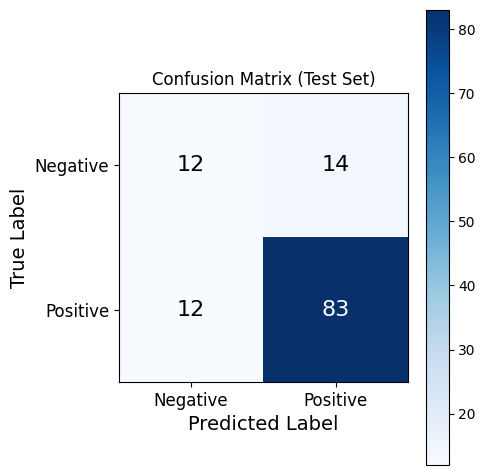

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
classes = ['Negative', 'Positive']  

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=16)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig("han_confusion_matrix.pdf")
plt.show()
